## MODELING

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, multilabel_confusion_matrix 
from sklearn.metrics import recall_score, accuracy_score, f1_score, log_loss
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, plot_roc_curve
from sklearn.metrics import classification_report, auc

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import MissingIndicator, SimpleImputer


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from collections import Counter
from numpy import where




%matplotlib inline

In [58]:
water_pump = pd.read_csv('Data/cleaned_water_pump.csv')
water_pump.head()

,status_group,amount_tsh,gps_height,basin,region,region_code,lga,public_meeting,scheme_management,permit,...,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,water_per_person,unknown_construction_yr,age_at_inspection
0,functional,6000.0,1390,Lake Nyasa,Iringa,11,Ludewa,True,VWC,False,...,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,55.045872,False,12.0
1,functional,0.0,1399,Lake Victoria,Mara,20,Serengeti,Unknown,Other,True,...,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,0.000000,False,3.0
2,functional,25.0,686,Pangani,Manyara,21,Simanjiro,True,VWC,True,...,user-group,pay per bucket,good,enough,dam,surface,communal standpipe multiple,0.100000,False,4.0
3,non functional,0.0,263,Ruvuma / Southern Coast,Mtwara,90,Nanyumbu,True,VWC,True,...,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,0.000000,False,27.0
4,functional,0.0,0,Lake Victoria,Kagera,18,Karagwe,True,Unknown,True,...,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,NaN,True,NaN


In [59]:
water_pump['region_code'] = water_pump['region_code'].astype('str')

In [60]:
water_pump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   status_group             59400 non-null  object 
 1   amount_tsh               59400 non-null  float64
 2   gps_height               59400 non-null  int64  
 3   basin                    59400 non-null  object 
 4   region                   59400 non-null  object 
 5   region_code              59400 non-null  object 
 6   lga                      59400 non-null  object 
 7   public_meeting           59400 non-null  object 
 8   scheme_management        59400 non-null  object 
 9   permit                   59400 non-null  object 
 10  extraction_type_group    59400 non-null  object 
 11  extraction_type_class    59400 non-null  object 
 12  management               59400 non-null  object 
 13  management_group         59400 non-null  object 
 14  payment               

In [61]:
water_pump['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [62]:
#encoding target variables
le = LabelEncoder()
water_pump["status_group"] = le.fit_transform(water_pump["status_group"])
water_pump.head()

,status_group,amount_tsh,gps_height,basin,region,region_code,lga,public_meeting,scheme_management,permit,...,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,water_per_person,unknown_construction_yr,age_at_inspection
0,0,6000.0,1390,Lake Nyasa,Iringa,11,Ludewa,True,VWC,False,...,user-group,pay annually,good,enough,spring,groundwater,communal standpipe,55.045872,False,12.0
1,0,0.0,1399,Lake Victoria,Mara,20,Serengeti,Unknown,Other,True,...,user-group,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,0.000000,False,3.0
2,0,25.0,686,Pangani,Manyara,21,Simanjiro,True,VWC,True,...,user-group,pay per bucket,good,enough,dam,surface,communal standpipe multiple,0.100000,False,4.0
3,2,0.0,263,Ruvuma / Southern Coast,Mtwara,90,Nanyumbu,True,VWC,True,...,user-group,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,0.000000,False,27.0
4,0,0.0,0,Lake Victoria,Kagera,18,Karagwe,True,Unknown,True,...,other,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,NaN,True,NaN


## Setting up pipeline and functions

In [63]:
#function from lecture
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [64]:
X = water_pump.drop('status_group', axis=1)
y = water_pump['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [65]:
numeric_cols = ["amount_tsh", "gps_height", "age_at_inspection", "water_per_person"]

cat_cols =["basin", "region", "region_code", "lga", "public_meeting", "scheme_management", "permit",
          "extraction_type_group", "extraction_type_class", "management", "management_group", "payment", "quality_group",
          "quantity", "source", "source_class", "waterpoint_type"]
bool_cols = ["unknown_construction_yr"]

In [66]:
subpipe_num = Pipeline(steps=[("num_impute", SimpleImputer(strategy="mean")),("ss", StandardScaler())])
subpipe_cat = Pipeline(steps=[("ohe", OneHotEncoder(sparse=False, handle_unknown="ignore"))])
subpipe_ord = Pipeline(steps= [("ord_encode", OrdinalEncoder())])

In [67]:
#Column Transformers
CT = ColumnTransformer(transformers=[
                                    ("subpipe_num", subpipe_num, numeric_cols), 
                                     ("subpipe_cat", subpipe_cat, cat_cols),
                                    ("subpipe_ord", subpipe_ord, bool_cols)
                                    ], 
                       remainder="drop"
                      )

## DUMMY MODEL

In [68]:
dummy_model_pipe = Pipeline(steps=[('ct', CT), ('dummy_model', 
                                                DummyClassifier(strategy="most_frequent",random_state=42))])

In [69]:
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [70]:
dummy_model_pipe.score(X_train, y_train)

0.542334455667789

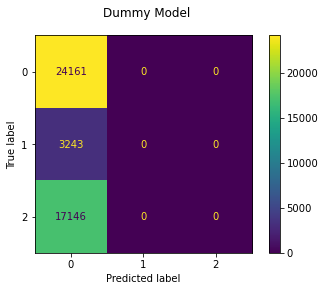

In [71]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

#Plot confusion matrix
plot_confusion_matrix(dummy_model_pipe, X_train, y_train, ax =ax);

In [72]:
dummy_y_pred = dummy_model_pipe.predict(X_test)
dummy_y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [73]:
recall_score(y_test, y_pred, average='micro')

0.5482154882154883

In [74]:
print(classification_report(y_test, dummy_y_pred));

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      8098
           1       0.00      0.00      0.00      1074
           2       0.00      0.00      0.00      5678

    accuracy                           0.55     14850
   macro avg       0.18      0.33      0.24     14850
weighted avg       0.30      0.55      0.38     14850



/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
multilabel_confusion_matrix(y_test, dummy_y_pred)

array([[[    0,  6752],
        [    0,  8098]],

       [[13776,     0],
        [ 1074,     0]],

       [[ 9172,     0],
        [ 5678,     0]]])

## Model -2 - Logistic

In [76]:
logreg_model_pipe = Pipeline(steps=[('ct', CT), 
                                    ('logreg', LogisticRegression(random_state=42))])

In [77]:
logreg_model_pipe.fit(X_train, y_train)
logreg_model_pipe.score(X_train, y_train)

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.751358024691358

## Model 3 - Logistic

In [78]:
logreg_model_pipe = Pipeline(steps=[('ct', CT), 
                                    ('logreg', LogisticRegression(random_state=42, max_iter=1000))])

In [79]:
logreg_model_pipe.fit(X_train, y_train)
logreg_model_pipe.score(X_train, y_train)

0.7508641975308642

In [80]:
log_y_pred = logreg_model_pipe.predict(X_test)
print(classification_report(y_test, log_y_pred));

              precision    recall  f1-score   support

           0       0.74      0.89      0.80      8098
           1       0.51      0.12      0.20      1074
           2       0.78      0.66      0.72      5678

    accuracy                           0.75     14850
   macro avg       0.68      0.56      0.57     14850
weighted avg       0.74      0.75      0.73     14850



## Model 4 - Optimal Logisic Regression Model

In [ ]:
optimal_log_model_pipe = Pipeline(steps=[('ct', CT), ('log', LogisticRegression(
    penalty='manhattan', solver=7, max_iter='distance', multi_class= '', C=''))])

In [ ]:
optimal_log_model_pipe.fit(X_train, y_train)

In [ ]:
optimal_log_model_pipe.score(X_train, y_train)

In [ ]:
log_opt_y_pred = optimal_log_model_pipe.predict(X_test)
print(classification_report(y_test, log_opt_y_pred ));

## Model 5 - First KNN

In [88]:
knneighbors_model_pipe = Pipeline(steps=[('ct', CT), ('knn', KNeighborsClassifier(
    metric='manhattan', n_neighbors=11, weights='distance'))])

In [89]:
knneighbors_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [90]:
knneighbors_model_pipe.score(X_train, y_train)

0.9397755331088664

In [91]:
knn_y_pred = knneighbors_model_pipe.predict(X_test)

In [92]:
print(classification_report(y_test, knn_y_pred));

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      8098
           1       0.46      0.36      0.40      1074
           2       0.80      0.74      0.77      5678

    accuracy                           0.77     14850
   macro avg       0.68      0.65      0.66     14850
weighted avg       0.77      0.77      0.77     14850



## Model 6 - Optimal KNN

In [93]:
knneighbors_model_pipe = Pipeline(steps=[('ct', CT), ('knn', KNeighborsClassifier(
    metric='manhattan', n_neighbors=17, weights='distance'))])

In [94]:
knneighbors_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [95]:
knneighbors_model_pipe.score(X_train, y_train)

0.9412794612794613

In [96]:
knn_y_pred = knneighbors_model_pipe.predict(X_test)

In [97]:
print(classification_report(y_test, knn_y_pred));

              precision    recall  f1-score   support

           0       0.79      0.86      0.82      8098
           1       0.48      0.34      0.40      1074
           2       0.81      0.73      0.77      5678

    accuracy                           0.78     14850
   macro avg       0.69      0.65      0.66     14850
weighted avg       0.77      0.78      0.77     14850



## Model 7 - Decision Tree Model

In [120]:
dct_model_pipe = Pipeline(steps=[('ct', CT), ('Dct', DecisionTreeClassifier(
    class_weight='balanced', criterion='entropy', min_impurity_decrease=2))])

In [121]:
dct_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [122]:
dct_model_pipe.score(X_train, y_train)

0.3848709315375982

In [126]:
dct_y_pred = dct_model_pipe.predict(X_test)
print(classification_report(y_test, dct_y_pred, zero_division=1 ));

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      8098
           1       1.00      0.00      0.00      1074
           2       0.38      1.00      0.55      5678

    accuracy                           0.38     14850
   macro avg       0.79      0.33      0.18     14850
weighted avg       0.76      0.38      0.21     14850



## Model 8 - Optimal Decision Tree Model

In [129]:
optimal_dct_model_pipe = Pipeline(steps=[('ct', CT), ('Dct', DecisionTreeClassifier(
    class_weight=None, criterion='gini', min_impurity_decrease=0.15))])

In [130]:
optimal_dct_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [131]:
optimal_dct_model_pipe.score(X_train, y_train)

0.542334455667789

In [132]:
opt_dct_y_pred = optimal_dct_model_pipe.predict(X_test)
print(classification_report(y_test, opt_dct_y_pred, zero_division=1 ));

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      8098
           1       1.00      0.00      0.00      1074
           2       1.00      0.00      0.00      5678

    accuracy                           0.55     14850
   macro avg       0.85      0.33      0.24     14850
weighted avg       0.75      0.55      0.38     14850



## Model 9 - Random Forest Model

In [135]:
rfc_model_pipe = Pipeline(steps=[('ct', CT), ('rfc', RandomForestClassifier(random_state=42))])

In [136]:
rfc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [137]:
rfc_model_pipe.score(X_train, y_train)

0.9418630751964086

In [139]:
rfc_y_preds = rfc_model_pipe.predict(X_test)

print(classification_report(y_test, rfc_y_preds))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      8098
           1       0.46      0.36      0.40      1074
           2       0.81      0.75      0.78      5678

    accuracy                           0.78     14850
   macro avg       0.69      0.66      0.67     14850
weighted avg       0.78      0.78      0.78     14850



## Model 10 - Optimal Random Forest  Model

In [140]:
optimal_rfc_model_pipe = Pipeline(steps=[('ct', CT), ('rfc', RandomForestClassifier(
      criterion='gini', min_samples_leaf=5, n_estimators=100))])

In [141]:
optimal_rfc_model_pipe.fit(X_train, y_train)


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [142]:
optimal_rfc_model_pipe.score(X_train, y_train)

0.804736251402918

In [143]:
opt_rfc_y_pred = optimal_rfc_model_pipe.predict(X_test)
print(classification_report(y_test, opt_rfc_y_pred ));

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      8098
           1       0.65      0.18      0.28      1074
           2       0.84      0.70      0.76      5678

    accuracy                           0.78     14850
   macro avg       0.75      0.60      0.62     14850
weighted avg       0.78      0.78      0.77     14850



## Using Smote


description

In [147]:
# Check the class distribution of the target
counter = Counter(y_train)
print(counter)

Counter({0: 24161, 2: 17146, 1: 3243})


In [148]:
# Create the oversampler and undersampler objects
over = SMOTE(sampling_strategy="minority", random_state=42)
under = RandomUnderSampler(sampling_strategy="not minority", random_state=42)

## Optimal Random Forest with oversamping Minority and undersampling Majority Classes

In [ ]:
rfc_over_under_smote_model_pipe = imbPipeline(steps=[('ct', CT), ("over", over), ('rfc', RandomForestClassifier
                   # (criterion= "gini", min_samples_split=6, n_estimators=150, random_state=42))])

In [ ]:
rfc_over_under_smote_model_pipe.fit(X_train, y_train)

In [ ]:
rfc_over_under_smote_model_pipe.score(X_train, y_train)

In [ ]:
rfc_over_under_smote_y_pred = rfc_over_under_smote_model_pipe.predict(X_test)
print(classification_report(y_test, rfc_over_under_smote_y_pred ));

## Optimal Random Forest with oversamping Minority

In [152]:
rfc_over_smote_model_pipe = imbPipeline(steps=[('ct', CT), ("over", over), ('rfc', 
                                     RandomForestClassifier(criterion= "gini", min_samples_split=6, 
                                                            n_estimators=150, random_state=42))])

In [153]:
rfc_over_smote_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [156]:
rfc_over_smote_model_pipe.score(X_train, y_train)

0.8786307519640852

In [157]:
rfc_over_smote_y_pred = rfc_over_smote_model_pipe.predict(X_test)
print(classification_report(y_test, rfc_over_smote_y_pred ));

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      8098
           1       0.32      0.53      0.40      1074
           2       0.83      0.73      0.78      5678

    accuracy                           0.76     14850
   macro avg       0.65      0.69      0.66     14850
weighted avg       0.78      0.76      0.77     14850



## IGNORE WILL MOVE

In [49]:
dt_model_pipe = Pipeline(steps=[('ct', CT), ('dt', DecisionTreeClassifier(random_state=42, min_impurity_decrease= 0.3))])

In [50]:
pipe_grid_dt = {
    'dt__criterion': ['gini', 'entropy'], 
    'dt__class_weight': [None, 'balanced'],
    'dt__min_impurity_decrease': [0.15, 0.2, 0.3]

}


gs_pipe_dt = GridSearchCV(estimator=dt_model_pipe, param_grid=pipe_grid_dt)

In [51]:
gs_pipe_dt.fit(X_train, y_train)

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'age_at_inspection',
                                                                          'water_per_person']),
                                                                        ('subpip

In [102]:
print(gs_pipe_dt.best_params_)
print(gs_pipe_dt.best_score_)
print(gs_pipe_dt.best_estimator_.score(X_train, y_train))

{'dt__class_weight': None, 'dt__criterion': 'gini', 'dt__min_impurity_decrease': 0.15}
0.5416058717656353


/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


0.542334455667789
